In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

In [ ]:
# Load dataset
df = pd.read_csv("Property_Dataset - Property_Dataset.csv")


In [ ]:
# Define categorical and numerical columns
categorical_cols = ["Property_Type", "Category"]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['Estimated_Price']]


In [ ]:
# ------------------------- 1. Regression -------------------------
X_reg = df.drop(columns=["Estimated_Price"])
y_reg = df["Estimated_Price"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
], remainder="passthrough")

reg_model = Pipeline([
    ("pre", preprocessor),
    ("reg", RandomForestRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

print("1. Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))
print()

1. Regression Performance:
MAE: 128470.325
RMSE: 163047.28599588832
R² Score: 0.9991016687133071



In [ ]:
# ------------------------- 2. Classification (Luxury vs Standard) -------------------------
df['Luxury_Label'] = df['Category'].apply(lambda x: 1 if x == 'Luxury' else 0)
X_cls = df.drop(columns=['Estimated_Price', 'Category', 'Luxury_Label'])
y_cls = df['Luxury_Label']

# Define a new preprocessor for the classification task,
# excluding 'Category' as it's dropped from features
preprocessor_cls = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), ["Property_Type"]) # Only include 'Property_Type'
], remainder="passthrough")

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
cls_model = Pipeline([
    ("pre", preprocessor_cls), # Use the new preprocessor
    ("clf", RandomForestClassifier(random_state=42))
])
cls_model.fit(X_train_c, y_train_c)
print("2. Classification Accuracy (Luxury vs Standard):", cls_model.score(X_test_c, y_test_c))
print()

2. Classification Accuracy (Luxury vs Standard): 0.99



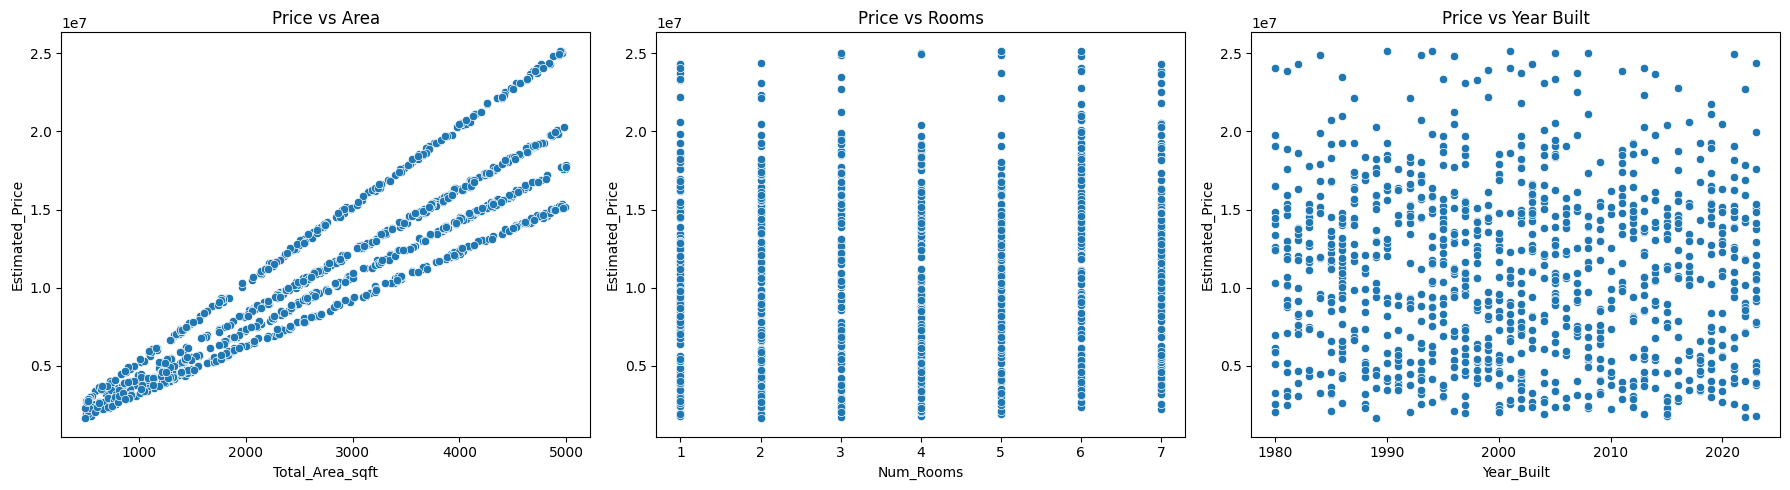

In [ ]:
# ------------------------- 3. Price Trend Visualizations -------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=df, x='Total_Area_sqft', y='Estimated_Price', ax=axes[0])
axes[0].set_title('Price vs Area')

sns.scatterplot(data=df, x='Num_Rooms', y='Estimated_Price', ax=axes[1])
axes[1].set_title('Price vs Rooms')

sns.scatterplot(data=df, x='Year_Built', y='Estimated_Price', ax=axes[2])
axes[2].set_title('Price vs Year Built')
plt.tight_layout()
plt.show()

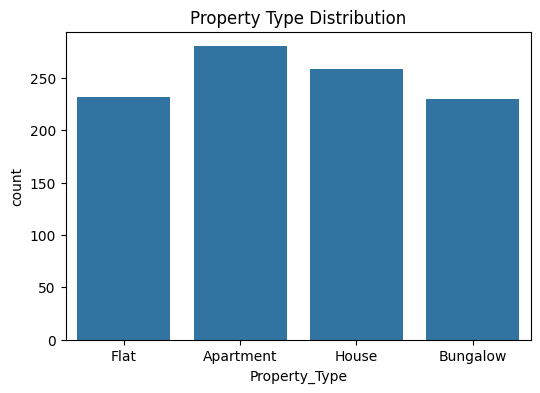

In [ ]:
# ------------------------- 4. Property Type Distribution -------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Property_Type')
plt.title("Property Type Distribution")
plt.show()

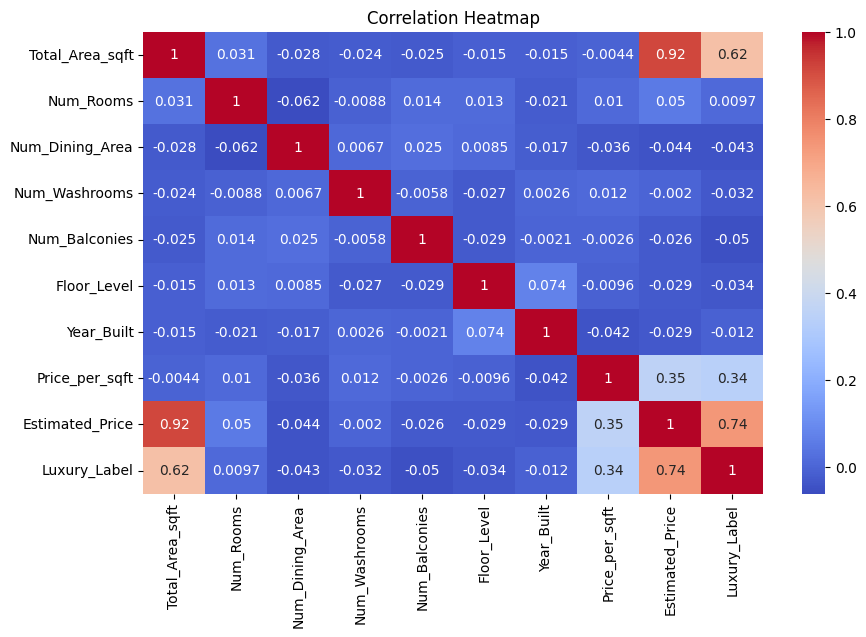

In [ ]:
# ------------------------- 5. Correlation Heatmap -------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

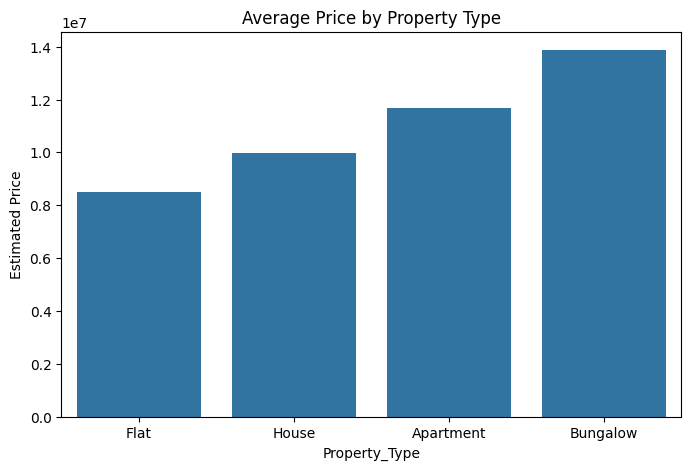

In [ ]:
# ------------------------- 6. Average Price by Property Type -------------------------
avg_price = df.groupby('Property_Type')['Estimated_Price'].mean().sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.title("Average Price by Property Type")
plt.ylabel("Estimated Price")
plt.show()

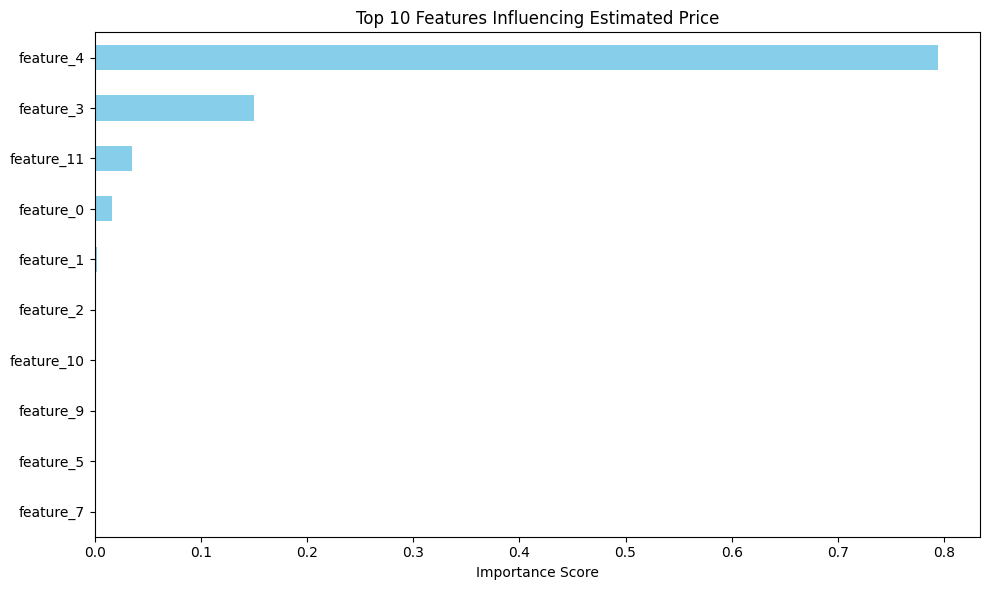

In [ ]:
# ------------------------- 7. Feature Importance -------------------------
# Access trained model and preprocessor from pipeline
regressor = reg_model.named_steps['reg']
fitted_preprocessor = reg_model.named_steps['pre']

# Get transformed feature names
try:
    df_names = fitted_preprocessor.get_df_names_out(input_df=X_train.columns)
except AttributeError:
    # Fallback if get_feature_names_out is not available
    df_names = [f"feature_{i}" for i in range(regressor.feature_importances_.shape[0])]

# Get feature importance scores from the model
importances = regressor.feature_importances_

# Create pandas Series for easy handling
importance_series = pd.Series(importances, index=df_names).sort_values(ascending=False)

# Display top N most important features
top_n = 10
plt.figure(figsize=(10, 6))
importance_series.head(top_n).plot(kind='barh', color='skyblue')
plt.title(f"Top {top_n} Features Influencing Estimated Price")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# ------------------------- 8. Classification with Area + Rooms + Type -------------------------
combo_features = ['Total_Area_sqft', 'Num_Rooms', 'Property_Type']
X_combo = df[combo_features]
y_combo = df['Luxury_Label']

combo_preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first'), ['Property_Type'])
], remainder='passthrough')

combo_model = Pipeline([
    ('pre', combo_preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

X_train_com, X_test_com, y_train_com, y_test_com = train_test_split(X_combo, y_combo, test_size=0.2, random_state=42)
combo_model.fit(X_train_com, y_train_com)
print("8. Combo Model Accuracy (Area + Rooms + Type):", combo_model.score(X_test_com, y_test_com))
print()


8. Combo Model Accuracy (Area + Rooms + Type): 0.995



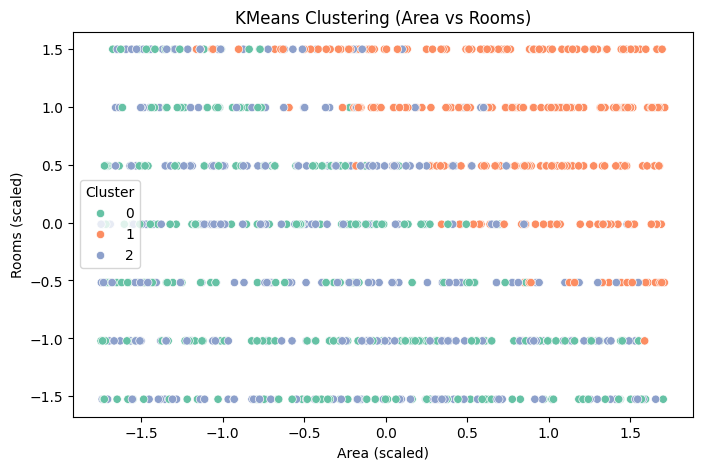

In [ ]:
# ------------------------- 9. Clustering -------------------------
clust_features = df[['Total_Area_sqft', 'Num_Rooms', 'Num_Washrooms', 'Price_per_sqft']]
scaled_features = StandardScaler().fit_transform(clust_features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=df['Cluster'], palette='Set2')
plt.title("KMeans Clustering (Area vs Rooms)")
plt.xlabel("Area (scaled)")
plt.ylabel("Rooms (scaled)")
plt.show()

Decision Tree Accuracy: 0.99


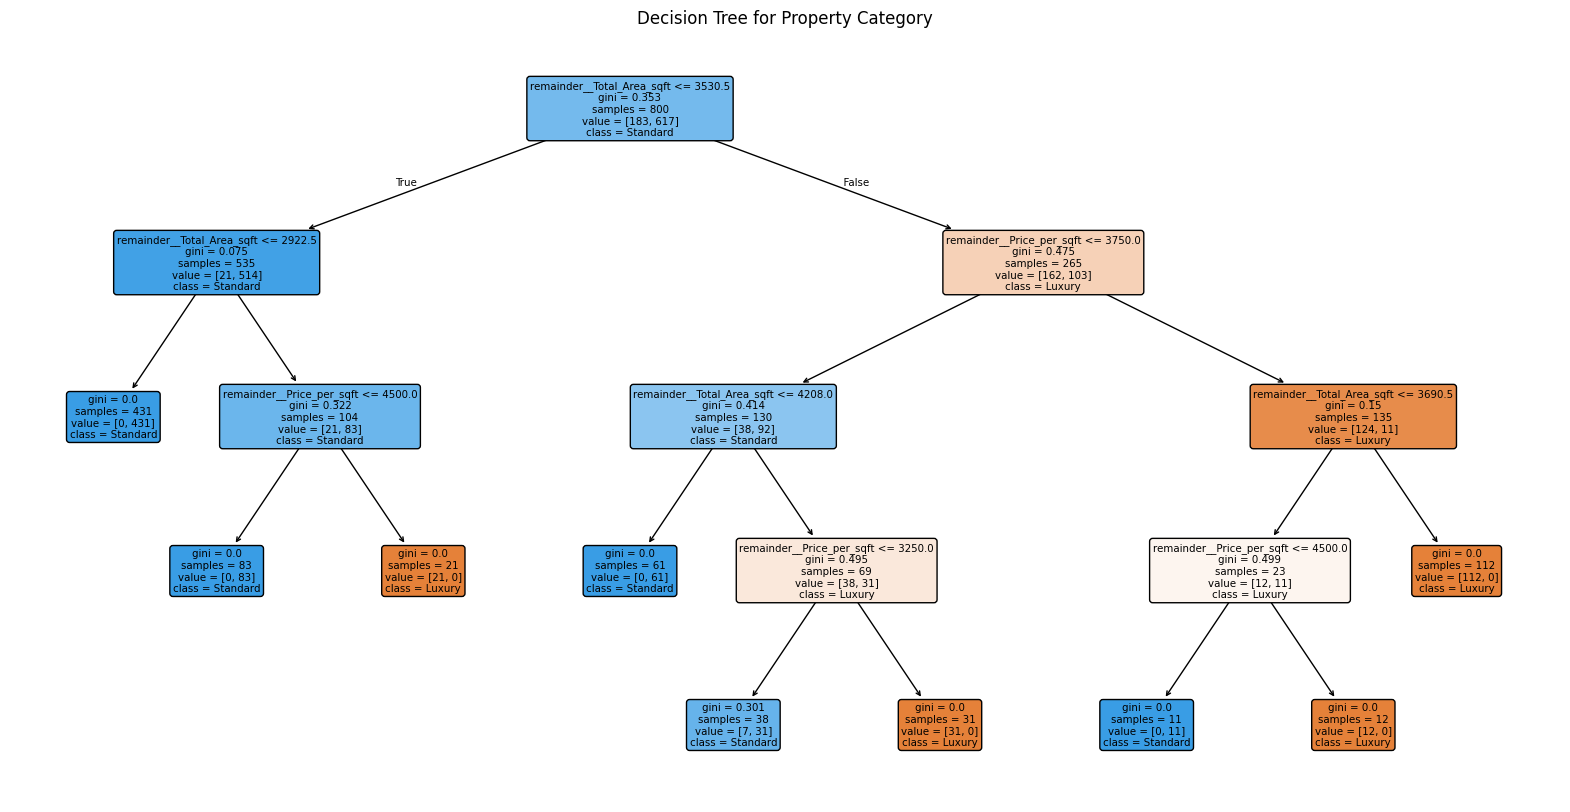

In [ ]:
# ------------------------- 10. Decision Tree for Category -------------------------
# Define features and target
X_tree = df.drop(columns=['Estimated_Price', 'Category', 'Luxury_Label', 'Cluster'])
y_tree = df['Category']

# Define new preprocessor (excluding 'Category' which is the target)
tree_categorical_cols = ["Property_Type"]  # include other categorical columns if needed
tree_preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), tree_categorical_cols)
], remainder="passthrough")

# Split the dataset
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42
)

# Create the pipeline
tree_pipeline = Pipeline([
    ("pre", tree_preprocessor),
    ("tree", DecisionTreeClassifier(max_depth=4, random_state=42))
])

# Fit the model
tree_pipeline.fit(X_train_tree, y_train_tree)

# Accuracy (optional)
print("Decision Tree Accuracy:", tree_pipeline.score(X_test_tree, y_test_tree))

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree_pipeline.named_steps['tree'],
    feature_names=tree_pipeline.named_steps['pre'].get_feature_names_out(),
    class_names=tree_pipeline.named_steps['tree'].classes_,
    filled=True, rounded=True
)
plt.title("Decision Tree for Property Category")
plt.show()
